In [ ]:
import xgboost as xgb
import polars as pl
import cupy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from xgboost import DMatrix, train as xgb_train
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import graphviz
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import re
import os
from graphviz import Source
import subprocess
import shap

**Load data into the Polars Dataframe**

In [ ]:
def load_data(file_path, feature_columns, target_column):
    """
    Load dataset from a file using Polars and prepare features (X) and target (y).
    
    Args:
        file_path (str): Path to the dataset file.
        feature_columns (list of str): List of column names to be used as features.
        target_column (str): Name of the column to be used as the target.

    Returns:
        tuple: Features (X) as NumPy array, Target (y) as NumPy array.
    """
    # Read dataset using Polars
    data = pl.read_csv(file_path)
    
    # Select features and target based on column names
    X = data.select(feature_columns)
    y = data.select(target_column)

    return X,y  # Convert Polars DataFrame to NumPy arrays

**Determine the Optimal XGBoost Model**

In [7]:
def train_optimal_xgb(X_train, y_train):
    try:
        train_dmatrix = DMatrix(X_train, label=y_train)
        # Define training parameters
        params = {
            "objective": "reg:squarederror",  # Regression task
            "eta": 0.01,                      # Learning rate
            "max_depth": 5,                   # Maximum depth of each tree
            "subsample": 0.8,                 # Fraction of samples used for training each tree
            "colsample_bytree": 1.0           # Fraction of features used for training each tree
        }
        # Define a range of early_stopping_rounds to test
        early_stopping_values = [10, 20, 50, 60, 70, 80, 90, 100]

        best_results = {}
        for early_stop in early_stopping_values:
            cv_results = xgb.cv(
                params,
                train_dmatrix,
                num_boost_round=5000,              # Large number of rounds
                nfold=200,                           # 3-fold cross-validation
                metrics=["rmse", "mae"],                    # Metric to evaluate
                early_stopping_rounds=early_stop,  # Test different values
                verbose_eval=10,                   # Print evaluation every 10 rounds
                as_pandas=True,                    # Return results as a Pandas DataFrame
            )
            # Store the results
            best_results[early_stop] = {
                "best_num_boost_round": cv_results.shape[0],
                "best_rmse": cv_results["test-rmse-mean"].min(),
            }

        # Find the optimal early_stopping_rounds
        optimal_early_stop = min(best_results, key=lambda k: best_results[k]["best_rmse"])
        optimal_num_boost_round = best_results[optimal_early_stop]["best_num_boost_round"]

        print(f"Optimal early_stopping_rounds: {optimal_early_stop}")
        print(f"Optimal num_boost_round: {optimal_num_boost_round}")
    
    except Exception as e:
        raise RuntimeError(f"Error while training model: {e}")

**Train the XGBoost Model with certain features being included**

In [8]:
def train_xgb_model_with_features(X_train, y_train, X_test, y_test, feature_names):
    """
    Train an XGBoost regressor model with explicit feature names and evaluate performance on the test set.
    Optionally standardize or normalize continuous features.

    Args:
        X_train (np.ndarray): Training data (features).
        y_train (np.ndarray): Training data (target).
        X_test (np.ndarray): Test data (features).
        y_test (np.ndarray): Test data (target).
        feature_names (list): List of explicit feature names.
        scale_type (str): Type of scaling to apply ("standardize" or "normalize").

    Returns:
        model (xgb.Booster): Trained XGBoost model.
        performance_metrics (dict): A dictionary containing RMSE, MSE, and R² metrics.
    """
    try:
        # Create DMatrix for training and testing
        train_dmatrix = DMatrix(X_train, label=y_train, feature_names = feature_names)
        test_dmatrix = DMatrix(X_test, label=y_test, feature_names = feature_names)

        # Define training parameters
        params = {
            "objective": "reg:squarederror",  # Regression task
            "eta": 0.01,                      # Learning rate
            "max_depth": 5,                   # Maximum depth of each tree
            "subsample": 0.8,                 # Fraction of samples used for training each tree
            "colsample_bytree": 1.0           # Fraction of features used for training each tree
        }
        
        # Train the XGBoost model
        print("Training XGBoost Model...")
        model = xgb_train(
            params,
            train_dmatrix,
            num_boost_round=591,              # Equivalent to n_estimators
            evals=[(test_dmatrix, "test")],   # Monitor performance on the test set
            early_stopping_rounds=20,         # Stop training if no improvement for 20 rounds
            verbose_eval=100                   # Print evaluation metrics every 50 rounds
        )

        # Make predictions on the test set
        predictions = model.predict(test_dmatrix)

        # Calculate performance metrics
        mse = mean_squared_error(y_test, predictions)
        rmse = mse**0.5
        r2 = r2_score(y_test, predictions)

        # Log metrics
        print(f"Model RMSE (Root Mean Squared Error): {rmse:.2f}")
        print(f"Model MSE (Mean Squared Error): {mse:.2f}")
        print(f"Model R² (R-squared): {r2:.4f}")

        # Return the trained model and performance metrics
        performance_metrics = {
            "mse": mse,
            "rmse": rmse,
            "r2": r2,
        }

        return model, performance_metrics

    except Exception as e:
        raise RuntimeError(f"Error while training model: {e}")

**Grid Search for Best Parameters**

In [ ]:
#param_grid = {
            #'n_estimators': [400, 500, 600],  # Equivalent to num_boost_round
            #'learning_rate': [0.01, 0.1, 0.2],
            #'max_depth': [3, 5, 7],
            #'subsample': [0.8, 0.9, 1.0],
            #'colsample_bytree': [0.8, 0.9, 1.0]
       #}

#xgb_model = XGBRegressor(objective="reg:squarederror", eval_metric="rmse")

#grid_search = GridSearchCV( 
            #estimator=xgb_model,
            #param_grid=param_grid,
            #scoring="r2",
            #cv=100,  # 5-fold cross-validation
            #verbose=50,
            #n_jobs=-1  # Use all available CPU cores
        #)

#grid_search.fit(X_train, y_train)

#print("Best Parameters:", grid_search.best_params_)
#print("Best R² Score (Train):", grid_search.best_score_)

#best_model = grid_search.best_estimator_
#y_pred = best_model.predict(X_test)
#r2_test = r2_score(y_test, y_pred)
#print("R² Score (Test):", r2_test)


**Clean feature names for better consistency on tree output**

In [10]:
def clean_feature_names(feature_names):
    """
    Clean feature names to conform to xgb formatting rules:
    1. Replace spaces with underscores.
    2. Remove invalid characters.
    3. Prefix feature names that start with numbers with "col_" to avoid ambiguity.

    Args:
        feature_names (list): List of original feature names.

    Returns:
        list: Sanitized feature names safe for use in xgb and fmap files.
    """
    cleaned_names = []
    for name in feature_names:
        # Replace spaces with underscores
        name = re.sub(r'\s+', '_', name)
        # Remove non-alphanumeric characters except underscores
        name = re.sub(r'[^\w]', '', name)
        # Prefix feature names that start with a number to prevent ambiguity
        if name[0].isdigit():
            name = f"col_{name}"
        cleaned_names.append(name)
    return cleaned_names

**Write a fmap for decision tree initialisation**

In [11]:
def write_fmap(feature_names, filename="feature_map.fmap"):
    """
    Write an fmap file to map feature indices to human-readable names.

    Args:
        feature_names (list): List of feature names.
        filename (str): The name of the fmap file to write.

    Returns:
        None
    """
    # Clean the feature names
    sanitized_feature_names = clean_feature_names(feature_names)

    # Write output to fmap file
    with open(filename, "w") as f:
        for i, name in enumerate(sanitized_feature_names):
            f.write(f"{i}\t{name}\tq\n")  # 'q' for quantitative feature
    print(f"Feature map written to {filename} with sanitized feature names.")

**Plot the decision tree**

In [12]:
def plot_xgb_tree_with_custom_resolution(model, feature_names=None, tree_index=0, dpi=300):
    """
    Plot a specific tree from an xgb model with custom resolution (DPI).
    Automatically creates and uses an fmap file if feature names are provided.
    High resolution is achieved via the Graphviz 'dot' command-line interface.

    Args:
        model (xgb.Booster): The trained xgb Booster model.
        feature_names (list, optional): List of feature names for labeling.
        tree_index (int): The index of the tree to visualize (default: 0).
        dpi (int): The resolution of the rendered tree in dots per inch.

    Returns:
        str: The path to the generated high-resolution image file.
    """
    try:
        fmap_filename = None
        dot_filename = "xgb_tree.dot"
        output_filename = "xgb_tree.png"

        # Create fmap file if feature names are provided
        if feature_names:
            fmap_filename = "feature_map_temp.fmap"
            write_fmap(feature_names, filename=fmap_filename)
        else:
            # Use empty string if no feature map is needed
            fmap_filename = ""

        # Generate the tree graph as a Graphviz Source object
        graph = xgb.to_graphviz(
            model,
            num_trees=tree_index,
            fmap=fmap_filename
        )

        # Save the Graphviz Source object to a .dot file
        graph.save(dot_filename)

        # Use the Graphviz `dot` CLI to render the graph with the specified DPI
        command = [
            "dot",
            "-Tpng",                          # Set output format to PNG
            f"-Gdpi={dpi}",                   # Set DPI (resolution)
            dot_filename,                     # Input .dot file
            "-o", output_filename             # Output PNG file
        ]
        subprocess.run(command, check=True)

        # Cleanup temporary files
        if fmap_filename and os.path.exists(fmap_filename):
            os.remove(fmap_filename)
        if os.path.exists(dot_filename):
            os.remove(dot_filename)

        print(f"Tree rendered and saved to {output_filename} with DPI={dpi}")
        return output_filename

    except Exception as e:
        raise RuntimeError(f"Error while plotting xgb tree: {e}")

**Plot the bar chart of different feature importance**

In [13]:
def plot_feature_importance(model, feature_names, normalize=False):
    """
    Visualize the feature importance of an XGBoost model, with optional normalization.
    Parameters:
    - model: Trained XGBoost model (can be XGBRegressor or XGBClassifier).
    - feature_names: List of feature names used during training.
    - normalize: Whether to normalize the feature importance scores so they sum to 100 (default: False).
    """
    # Retrieve feature importance scores (raw counts of splits for each feature)
    importance_dict = model.get_score(importance_type='weight')
    
    # Use the importance dictionary directly (keys are feature names)
    sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
    
    # Extract feature names and their importance scores
    features, scores = zip(*sorted_importance)
    
    if normalize:
        # Normalize scores so they sum to 100
        total = sum(scores)
        scores = [(score / total) * 100 for score in scores]
    
    # Plot the feature importances
    plt.figure(figsize=(10, 8))
    y_positions = np.arange(len(features))  # Define y-axis positions for the bars
    bars = plt.barh(y_positions, scores, color="#2E6EFF")
    
    # Add percentage labels on the right-hand side of the bars
    for i, score in enumerate(scores):
        plt.text(score + 0.5, i, f"{score:.1f}%", va="center", fontsize=15, color="black")
    
    # Reverse the order to have the most important on top
    plt.gca().invert_yaxis()
    
    # Set axis labels and title with increased font size
    plt.xlabel("Feature Importance (%)" if normalize else "Feature Importance (Weight)", fontsize=15)
    plt.ylabel("Features", fontsize=15)
    plt.title("Overall Feature Importance", fontsize=15)
    
    # Adjust the x-axis scale to a maximum of 35%
    plt.xlim(0, 35)
    
    # Set y-axis ticks to feature names with increased font size
    plt.yticks(y_positions, features, fontsize=15)
    plt.xticks(fontsize=15)  # Increase font size of x-axis tick labels
    
    # Show the plot
    plt.show()

**Main Structure**

Training XGBoost Model...
[0]	test-rmse:5.10998
[100]	test-rmse:3.58593
[200]	test-rmse:3.24256
[300]	test-rmse:3.15861
[400]	test-rmse:3.12482
[500]	test-rmse:3.10785
[571]	test-rmse:3.09715
Model RMSE (Root Mean Squared Error): 3.10
Model MSE (Mean Squared Error): 9.59
Model R² (R-squared): 0.6366
Performance Metrics: {'mse': 9.592557907104492, 'rmse': 3.0971854815468336, 'r2': 0.6366364359855652}


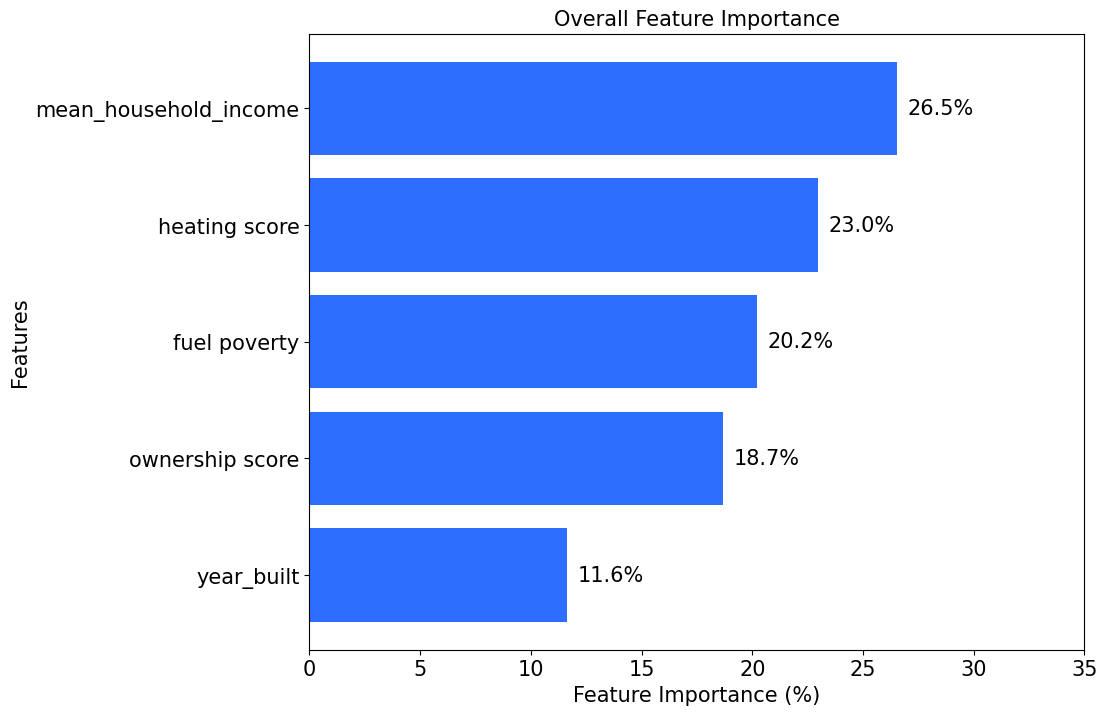

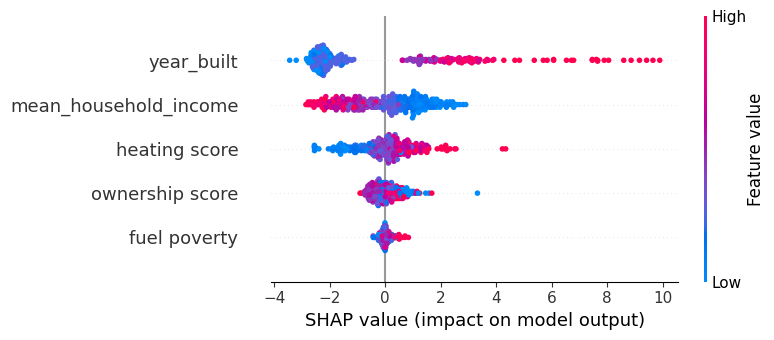

In [15]:
# Step 1: Load dataset
file_path = "filtered_data.csv"  # Replace with your CSV file path
feature_columns = ["mean_household_income", "fuel poverty", "year_built", "heating score", "ownership score"]
target_column = "energy efficiency"

X, y = load_data(file_path, feature_columns, target_column)

# Step 2: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=36)

# Step 3: Train xgb model#
model, metrics = train_xgb_model_with_features(
    X_train, y_train, X_test, y_test, feature_columns)

# Step 4: Print metrics
print("Performance Metrics:", metrics)

# Step 5: Plot feature importance
plot_feature_importance(model, feature_columns, normalize=True)
explainer = shap.Explainer(model)
shap_values = explainer(X_test.to_numpy())

# Step 6: Plot summary plot
shap.summary_plot(shap_values, X_test.to_numpy(), feature_names=X.columns)


**Dynamically Test Parameters**

In [16]:
# Dynamically generate test_size values from 0.10 to 0.30 in increments of 0.01
test_sizes = np.arange(0.10, 0.31, 0.01)


# Dynamically generate random_state values from 1 to 100
random_states = range(1, 101)

results = []

for test_size in test_sizes:
    for random_state in random_states:
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )
        
        # Train the model
        model, metrics = train_xgb_model_with_features(
            X_train, y_train, X_test, y_test, feature_columns
        )
        
        # Store results
        results.append({
            "test_size": test_size,
            "random_state": random_state,
            "rmse": metrics["rmse"],
            "r2": metrics["r2"],
        })

# Convert results to a DataFrame for analysis
results_df = pl.DataFrame(results)
best_result = results_df.filter(pl.col("r2") == results_df["r2"].max())
print("Best Result:", best_result)

Training XGBoost Model...
[0]	test-rmse:5.24254
[100]	test-rmse:3.84656
[200]	test-rmse:3.63297
[262]	test-rmse:3.62015
Model RMSE (Root Mean Squared Error): 3.62
Model MSE (Mean Squared Error): 13.10
Model R² (R-squared): 0.5245
Training XGBoost Model...
[0]	test-rmse:5.33567
[100]	test-rmse:3.99230
[200]	test-rmse:3.71880
[300]	test-rmse:3.67102
[373]	test-rmse:3.66467
Model RMSE (Root Mean Squared Error): 3.66
Model MSE (Mean Squared Error): 13.42
Model R² (R-squared): 0.5327
Training XGBoost Model...
[0]	test-rmse:5.31293
[100]	test-rmse:4.05757
[200]	test-rmse:3.85610
[300]	test-rmse:3.81831
[400]	test-rmse:3.80818
[406]	test-rmse:3.80705
Model RMSE (Root Mean Squared Error): 3.81
Model MSE (Mean Squared Error): 14.49
Model R² (R-squared): 0.4902
Training XGBoost Model...
[0]	test-rmse:5.08906
[100]	test-rmse:3.70787
[200]	test-rmse:3.45160
[300]	test-rmse:3.41357
[337]	test-rmse:3.41297
Model RMSE (Root Mean Squared Error): 3.41
Model MSE (Mean Squared Error): 11.65
Model R² (R-s

**Tree Plot Main Section**

In [17]:
with open('fmap.txt', 'w') as f:
    for i, name in enumerate(feature_columns):
        f.write(f"{i}\t{name}\tq\n")

# Clean Feature Names
cleaned_feature_columns = clean_feature_names(feature_columns)
print("Cleaned Feature Names: ", cleaned_feature_columns)

# Plot the Tree from XGBoost Model
graph = plot_xgb_tree_with_custom_resolution(
    model=model,
    feature_names=cleaned_feature_columns,  # Use cleaned feature names
    tree_index=0,                           # Index of the tree to visualize
    dpi=3500                                # High resolution
)

print("Tree visualization saved as 'my_tree.png'.")

Cleaned Feature Names:  ['mean_household_income', 'fuel_poverty', 'year_built', 'heating_score', 'ownership_score']
Feature map written to feature_map_temp.fmap with sanitized feature names.
Tree rendered and saved to xgb_tree.png with DPI=3500
Tree visualization saved as 'my_tree.png'.
